In [1]:
from sympy import *
import numpy as np
import numpy.linalg as la
from tabulate import tabulate
import scipy.optimize as opt

from matplotlib import pyplot as plt
font = {'fontname':'Times New Roman'}
size = {'fontsize':'14'}
#save_path = r'C:\Users\reape\Desktop\Sp24\NPRE 455\CP1\Plots\\'

In [2]:
#Part B
SigmaA1, SigmaA2, SigmaF1 = S('Sigma_A1, Sigma_A2, Sigma_F1')
D1, D2, nu, a, b, k = S('D_1, D_2, nu, a, b, k')

B = S('B')
L = S('L')

#Min/Max a
B = ((nu*SigmaF1/k-SigmaA1)/D1)**(1/2)
L = (D2/SigmaA2)**(1/2)

amin_crit = D1/D2*B*L*tan(B*a) - 1
amin_crit_subs = amin_crit.subs([(SigmaA1, 0.066), (SigmaA2, 0.000709), (SigmaF1, 0.02787), (D1, 0.79), (D2, 1), (nu, 2.4), (k, 1)])
amin = solve(amin_crit_subs, a)[0]

amax_crit = B**2 - pi**2/4/a**2
amax_crit_subs = amax_crit.subs([(SigmaA1, 0.066), (SigmaA2, 0.000709), (SigmaF1, 0.02787), (D1, 0.79), (D2, 1), (nu, 2.4), (k, 1)])
amax = solve(amax_crit_subs, a)[1]

print('Minimum and Maximum a [cm]')
display(amin, amax)

Minimum and Maximum a [cm]


23.5050218860147

46.8518711012992

In [3]:
#Part D
crit_cond = D1/D2 * B * L * tanh(b/L) * tan(B*a) - 1
crit_cond_subs = crit_cond.subs([(SigmaA1, 0.066), (SigmaA2, 0.000709), (SigmaF1, 0.02787), (D1, 0.79), (D2, 1), (nu, 2.4), (k, 1)])

a_arrayD = Matrix([5,10,15,20,25,30,35,40,45,50])
resultsD = zeros(len(a_arrayD),1)

for i in range(len(a_arrayD)):
    if a_arrayD[i] > amax: resultsD[i] = 'super'
    elif a_arrayD[i] < amin: resultsD[i] = 'sub'
    else: 
        resultsD[i] = crit_cond_subs.subs(a, a_arrayD[i])

print('Expressions will be calculated manually')
display(resultsD)

Expressions will be calculated manually


Matrix([
[                                            sub],
[                                            sub],
[                                            sub],
[                                            sub],
[1.10565768450885*tanh(0.0266270539113887*b) - 1],
[1.56913443647438*tanh(0.0266270539113887*b) - 1],
[2.37016444426389*tanh(0.0266270539113887*b) - 1],
[4.25363048186186*tanh(0.0266270539113887*b) - 1],
[16.0005411156788*tanh(0.0266270539113887*b) - 1],
[                                          super]])

  N    a [cm]    b [cm]        k
---  --------  --------  -------
 10        10        50  0.96688
 20        10        50  0.97559
 40        10        50  0.97257
 80        10        50  0.97407
160        10        50  0.97331
 10        25        50  1.00042
 20        25        50  0.99925
 40        25        50  0.99981
 80        25        50  0.99951
160        25        50  0.99966
 10        50        50  1.00858
 20        50        50  1.00828
 40        50        50  1.00812
 80        50        50  1.00804
160        50        50  1.008


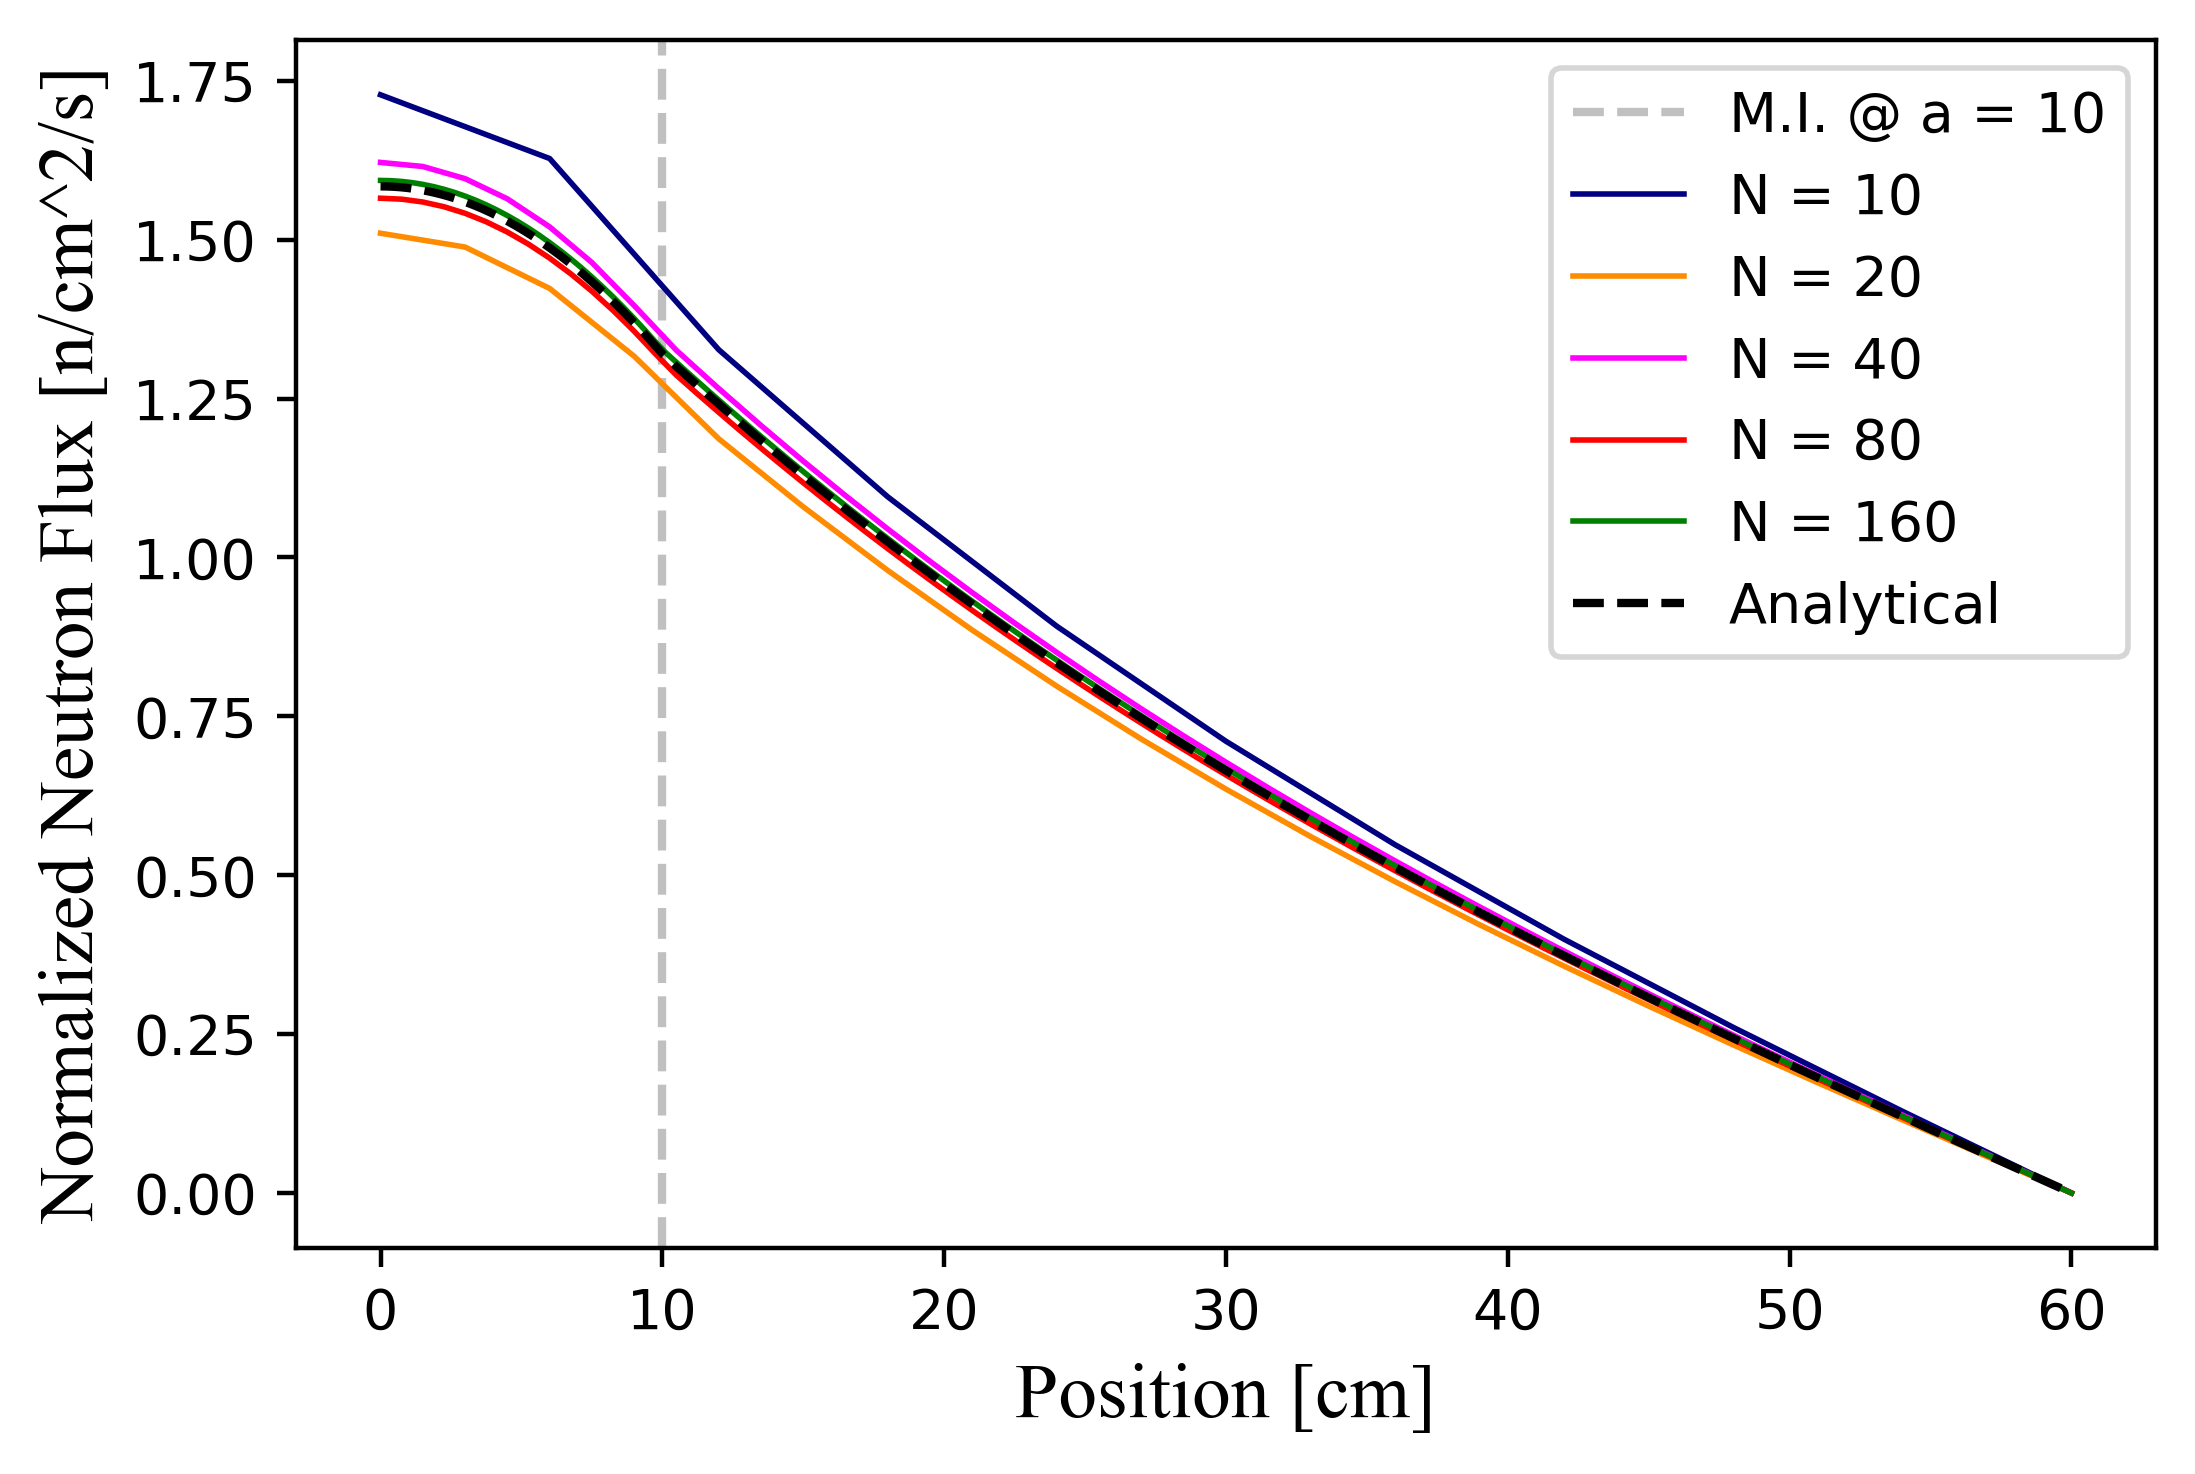

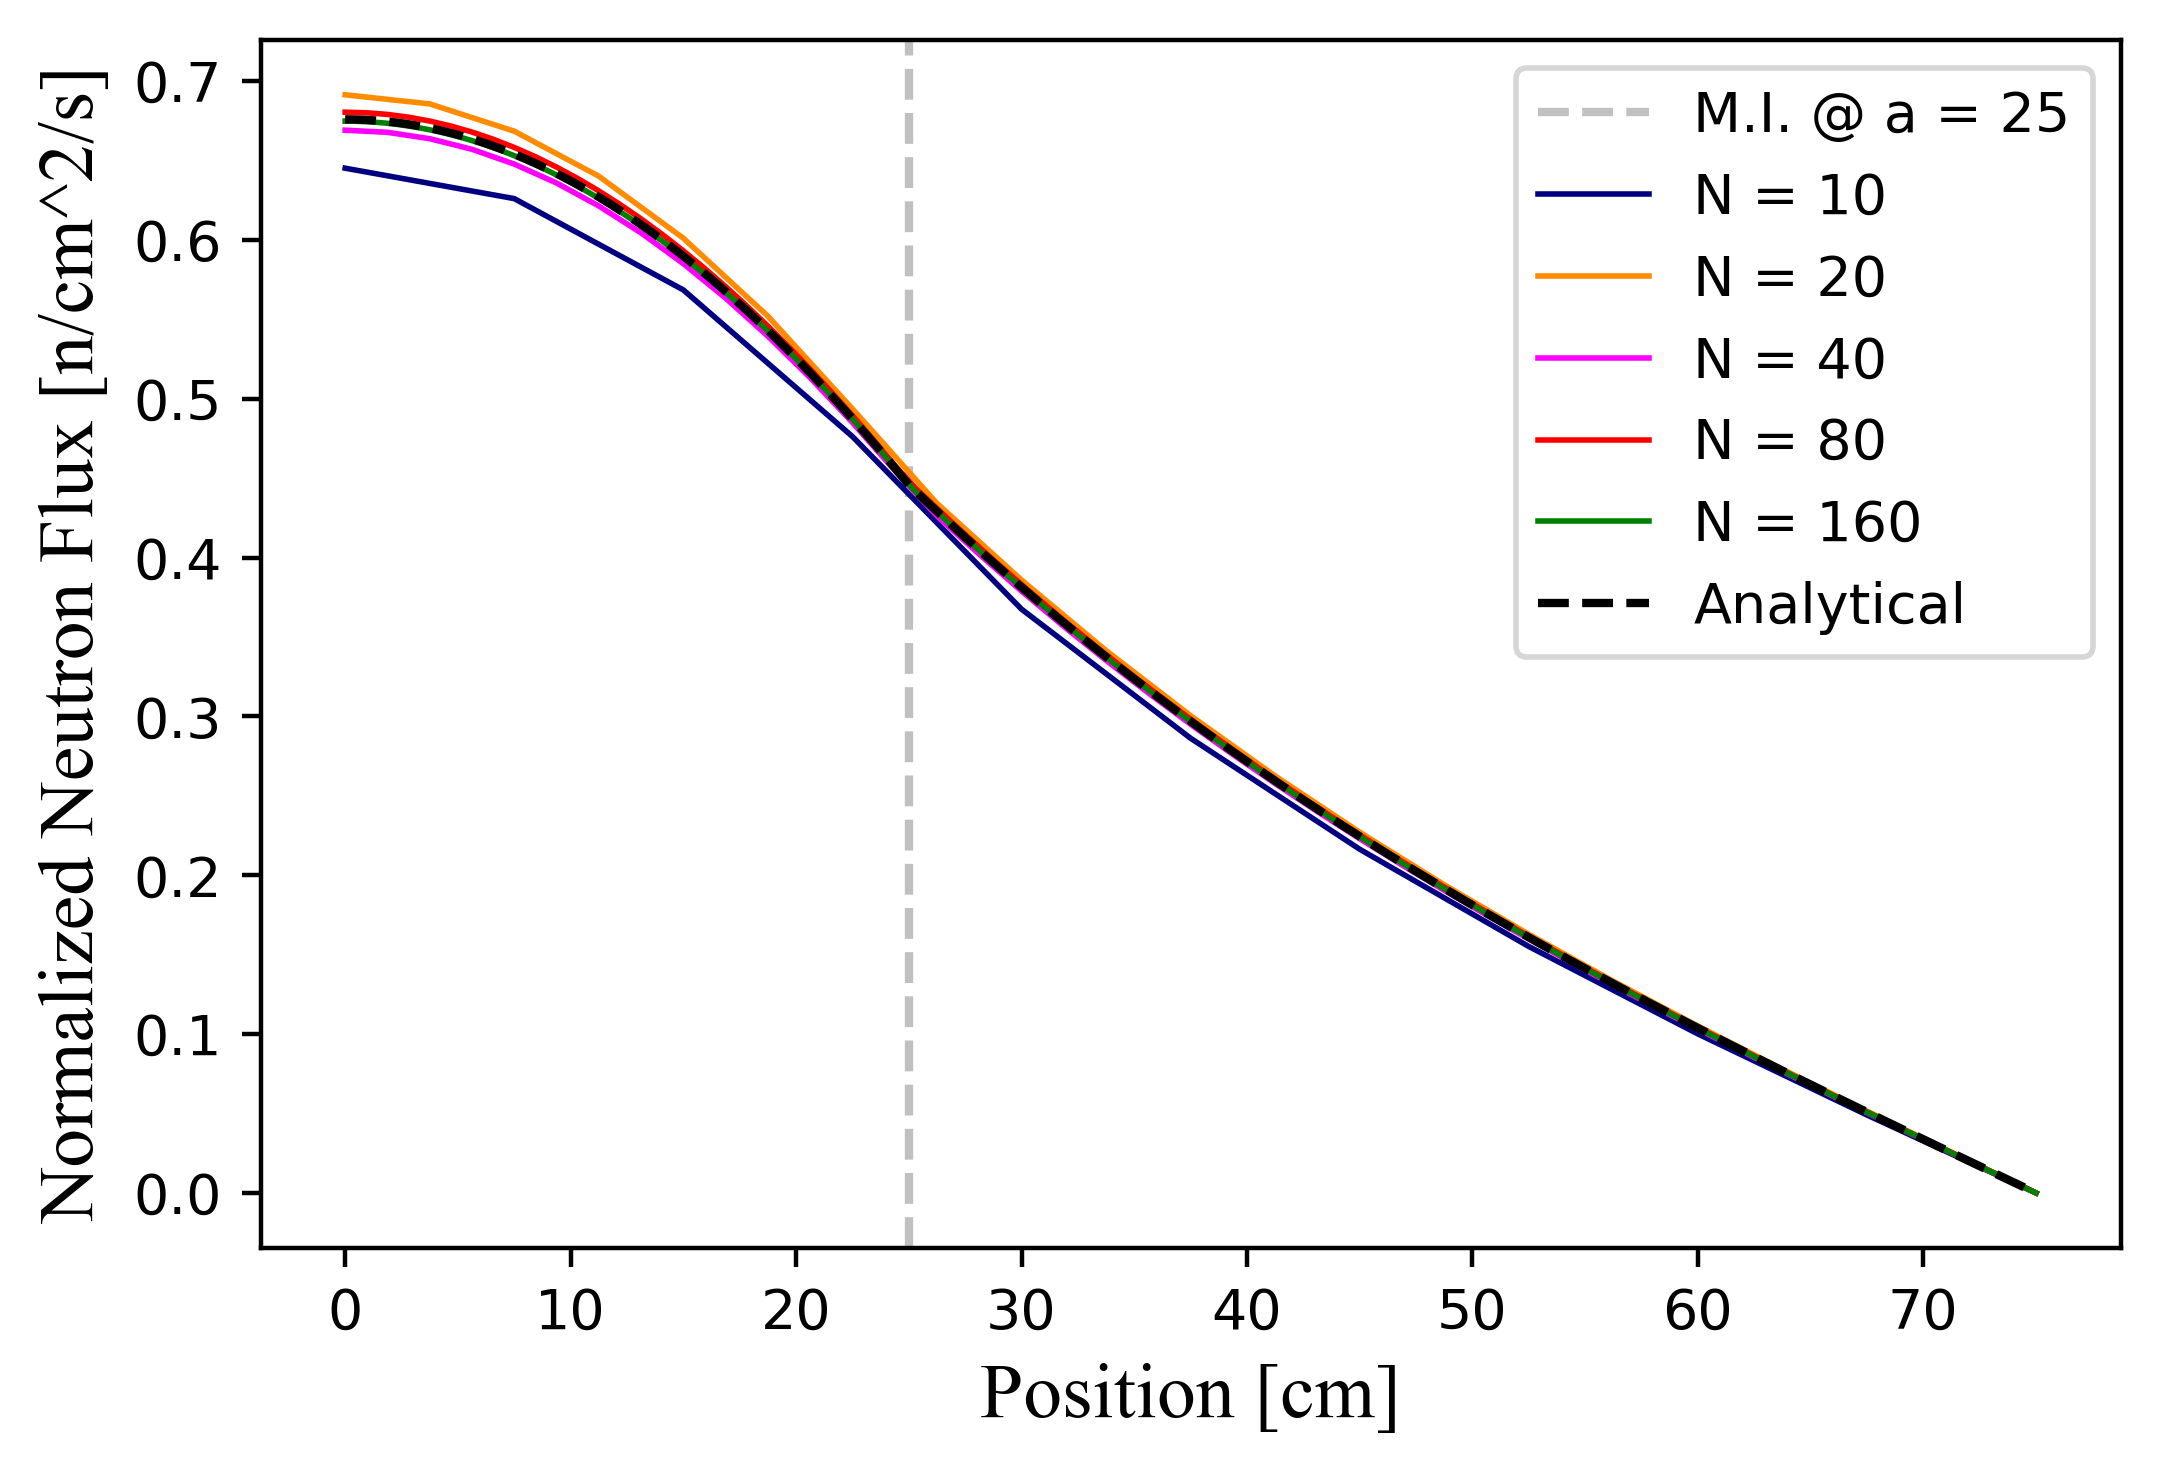

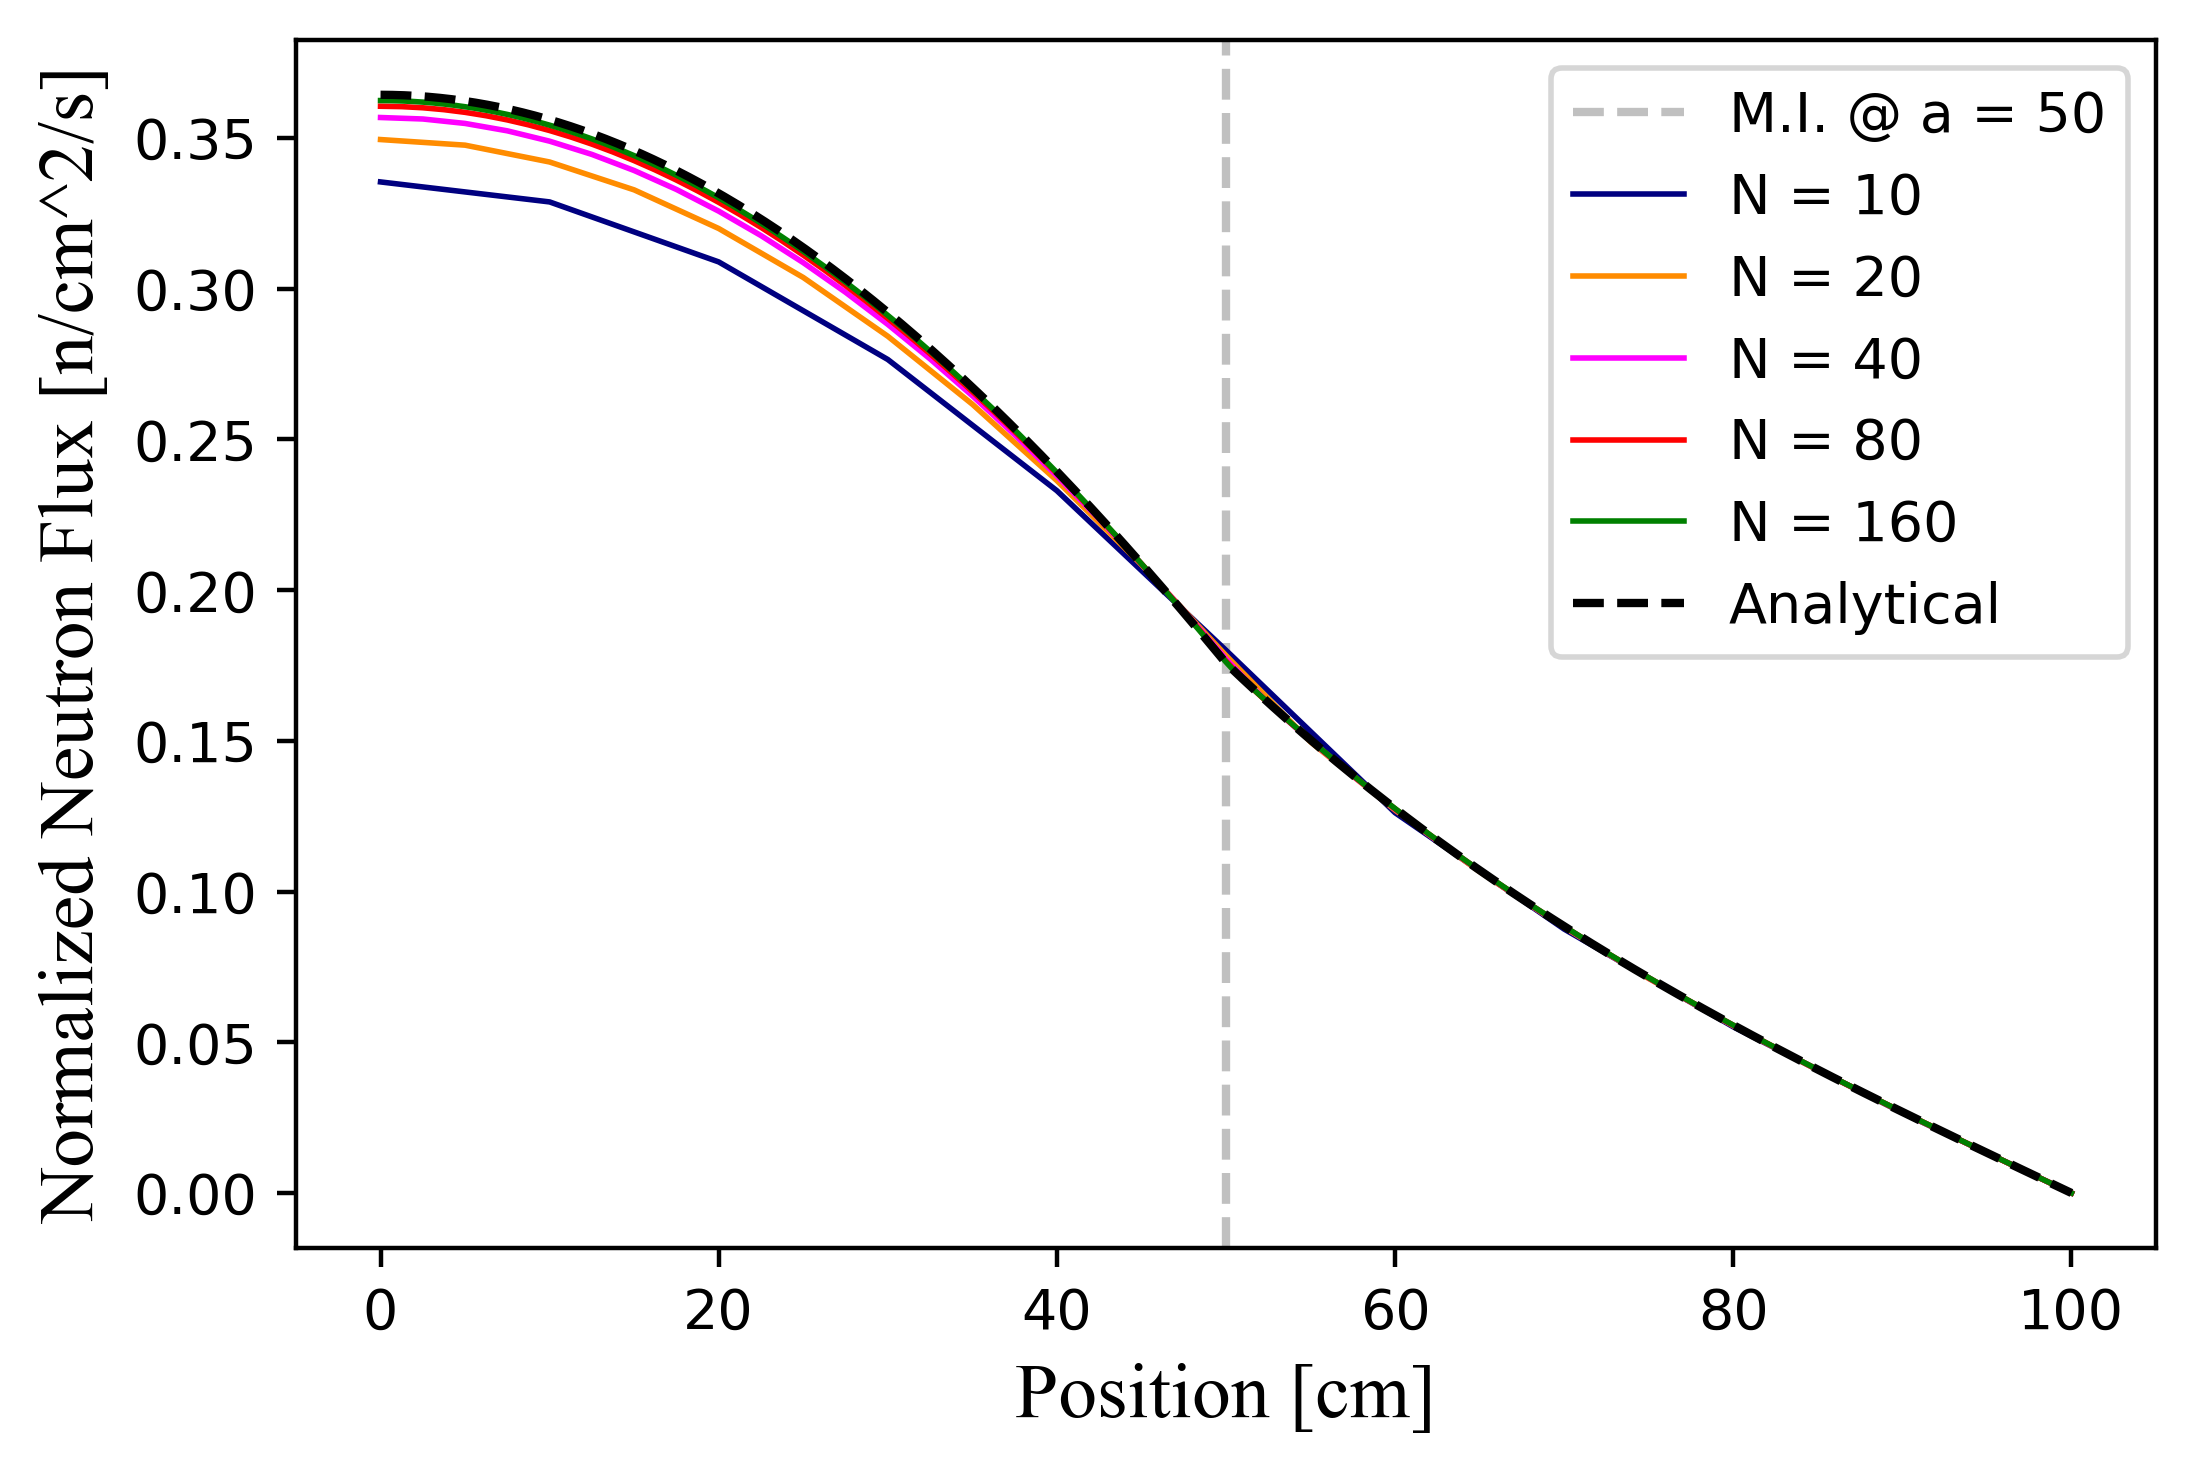

In [4]:
#Part E & F

#Constants
b = 50
D1 = 0.79
D2 = 1
SigmaA1 = 0.066
SigmaA2 = 0.000709
SigmaF1 = 0.02787
nu = 2.4
L2 = (D2/SigmaA2)**(1/2)

#######################################Benninging of the Functions######################################################
def flux_num(N, a, b):
    x_pos = np.linspace(0,a+b,N+1)
    h = x_pos[1]
    M = np.zeros((N+1, N+1))
    F = np.zeros(N+1)
    
    #Constant Arrays
    D_arr = np.zeros(N+1)
    Sig_arr = np.zeros(N+1)
    F = np.zeros(N+1)

    #CUT
    for i in range(len(x_pos)):
        if x_pos[i] <= a:
            D_arr[i] = D1 #D1
            Sig_arr[i] = SigmaA1 #SigmaA1
            F[i] = nu * SigmaF1
        else:
            D_arr[i] = D2 #D2
            Sig_arr[i] = SigmaA2 #SigmaA2
    F[0] = 0

    #M Boundary Conditions
    np.put(M, (0,1,2), (-3,4,-1))
    M[-1,-1] = 1
    
    #M Array Population
    for i in range(1, len(x_pos)-1):
        M[i,i-1] = -2*D_arr[i]/h**2*D_arr[i-1]/(D_arr[i-1]+D_arr[i]) #Lower Diag
        M[i,i] = 2*D_arr[i]/h**2*(D_arr[i-1]/(D_arr[i-1]+D_arr[i]) + D_arr[i+1]/(D_arr[i+1]+D_arr[i])) + Sig_arr[i] #On diag
        M[i,i+1] = -2*D_arr[i]/h**2*D_arr[i+1]/(D_arr[i+1]+D_arr[i]) #Upper Diag
    
    #Power Iteration
    epsilon, error1, error2 = 1e-6, 1, 1
    Flux0, k0 = np.ones(N+1), 1 
    step = 0
    
    #Looping
    while error1 > epsilon or error2 > epsilon:
    #Finding Flux1 & k1
        Flux1 = la.inv(M) @ (F*Flux0)/k0 #Eq 474
    
        top = np.trapz((F*Flux1), dx=h) #Eq 475
        bot = np.trapz((M@Flux1), dx=h)
        k1 = top/bot 
        
        #Finding Error
        error1 = la.norm(Flux1-Flux0, 2) / la.norm(Flux0, 2) #Eq 476
        error2 = abs(k1-k0)/k0 #Eq 477

        #Resetting Flux0 and k0
        Flux0, k0 = Flux1, k1
    
    #Normalizing Flux
    F[0] = nu * SigmaF1
    Flux0 /= np.trapz((F*Flux0), dx=h)
    
    return np.around(k0, 5), Flux0, np.trapz((F*Flux0), dx=h), M


def flux_num_plotting(N, a, b, graph_color):
    plt.plot(np.linspace(0,a+b,N+1), flux_num(N, a, b)[1], label="N = {}".format(N), 
              color=graph_color, linewidth = 1)


#Analytical Plotting    

#Getting K for each thickness
a_arr = np.array([10, 25, 50])
buck_guess = np.array([0.97, 1, 1.008])
k_arr = np.zeros(3)

def root_func(x):
    B = (((1/x)*nu*SigmaF1-SigmaA1)/D1)**.5
    return(L2*D1/D2*B*np.tan(B*a)*np.tanh(b/L2)-1)

for i in range(len(a_arr)):
    a = a_arr[i]
    k_arr[i] = opt.root(root_func, buck_guess[i]).x

def ana_plotting(a_sub):
    if a_sub == 10: k=k_arr[0]
    elif a_sub == 25: k=k_arr[1]
    else: k=k_arr[2]
    
    #Getting Plots for Analytical
    ana_pos = np.linspace(0,a_sub+50,1000)
    flux_ana = np.zeros(len(ana_pos))
    B = ((1/k*nu*SigmaF1 - SigmaA1)/D1)**(.5)
    C1 = B/nu/SigmaF1/np.sin(B*a_sub)

    F = np.zeros(1000)
    for i in range(1000):
        if ana_pos[i] <= a_sub:
            flux_ana[i] = C1*np.cos(B*ana_pos[i])
            F[i] = nu * SigmaF1
        else:
            flux_ana[i] = C1*np.cos(B*a_sub)/np.sinh(50/L2)*np.sinh((50+a_sub-ana_pos[i])/L2)
    flux_ana /= np.trapz((F*flux_ana), dx = ana_pos[1])
    plt.plot(ana_pos, flux_ana, label = 'Analytical', color = 'black', linestyle='--')
#This is kinda hard coded, but I have other things to do for now X_X

#######################################End of the Functions#############################################################

#Tabulating Results
N_arrayE = np.array([10, 20, 40, 80, 160])
a_arrayE = np.array([10, 25, 50])

resultsE = np.empty(4)
for i in range(len(a_arrayE)):
    for j in range(len(N_arrayE)):
        toAddE = np.array([N_arrayE[j], a_arrayE[i], 50, flux_num(N_arrayE[j], a_arrayE[i], 50)[0]])
        resultsE = np.vstack([resultsE, toAddE])
    plt.show()
        
resultsE = np.delete(resultsE, 0, 0)

headers = np.array(['N', 'a [cm]', 'b [cm]', 'k'])
print(tabulate(resultsE, headers))

#Plotting Flux
graph_colors = np.array(['navy','darkorange','fuchsia','red','green'])

mi_array = np.array([10, 25, 50])
for i in range(len(a_arrayE)):
    plt.figure(dpi=400)
    plt.axvline(mi_array[i], color = 'silver', linestyle = '--', label = "M.I. @ a = {}".format(mi_array[i]))
    for j in range(len(N_arrayE)):
        flux_num_plotting(N_arrayE[j], a_arrayE[i], 50, graph_colors[j])
    ana_plotting(a_arrayE[i])
    
    plt.ylabel('Normalized Neutron Flux [n/cm^2/s]',**font, **size)
    plt.xlabel('Position [cm]', **font, **size)
    plt.legend()
#    plt.savefig(save_path+'3D{}'.format(i))